# Predictionf for avarage monthly salary in Russia

'in file WAG_C_M.csv we have data from Jan 1993 till Aug 2016.'
'in file WAG_C_M_17.csv have data from Jan 1993 till May 2017 http://sophist.hse.ru/exes/tables/WAG_M.htm'

'Here we will analyze data, find optimal prediction model ARIMA' 

'Algorithm for model building'

1. Visualization
2. Dispersia stabilization
3. Differentiation
4. Selecting initial approximation for p,q,P,Q
5. Building and models comparing
6. Residues research
7. Comparing with real data

# Visualization
check data and visualize time row

            WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5
Populating the interactive namespace from numpy and matplotlib


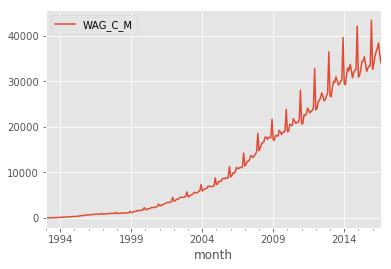

In [90]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
print data.head()
%pylab inline
matplotlib.style.use('ggplot')
data.plot()

# Dispersia stabilization

Next step is to make stabilization for time row, lets build STL-Decomposition of the row
and check The Augmented Dickey-Fuller test, zero hypothesis is that row is not stationary 

The Augmented Dickey-Fuller test: p=0.991850


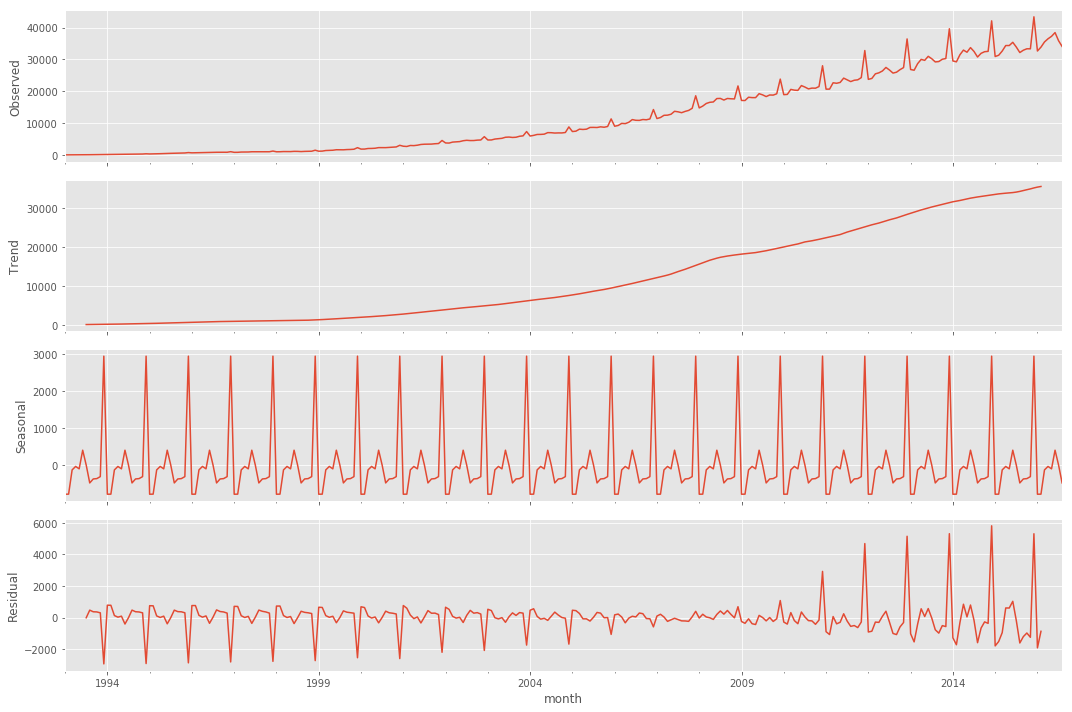

In [91]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("The Augmented Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

We could not neglect zero hypothesisas becuause it is grater than 0.05.

Apply Box-Cox Transformation for stabilizations dispersion

Optimal parameter for Box-Cox transormation 0.263202
The Augmented Dickey-Fuller test: p=0.696899


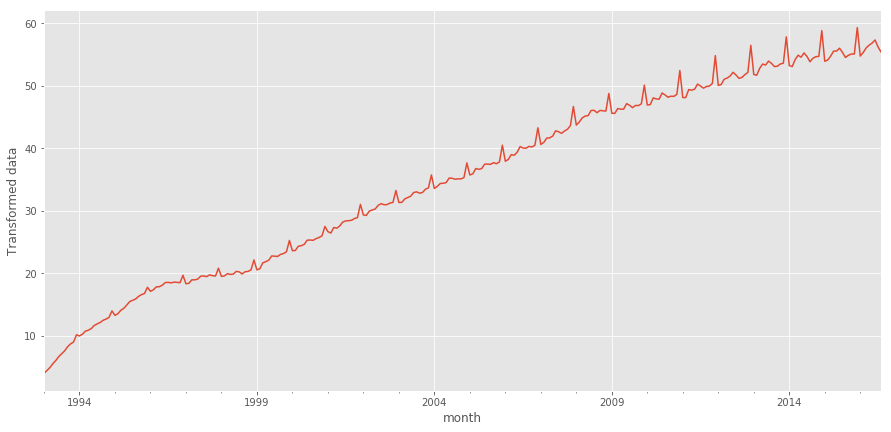

In [92]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed data')
print("Optimal parameter for Box-Cox transormation %f" % lmbda)
print("The Augmented Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

We still see trand and zero hypothesis could not be neglected, in this case we will use Seasonal differentiation

The Augmented Dickey-Fuller test: p=0.014697


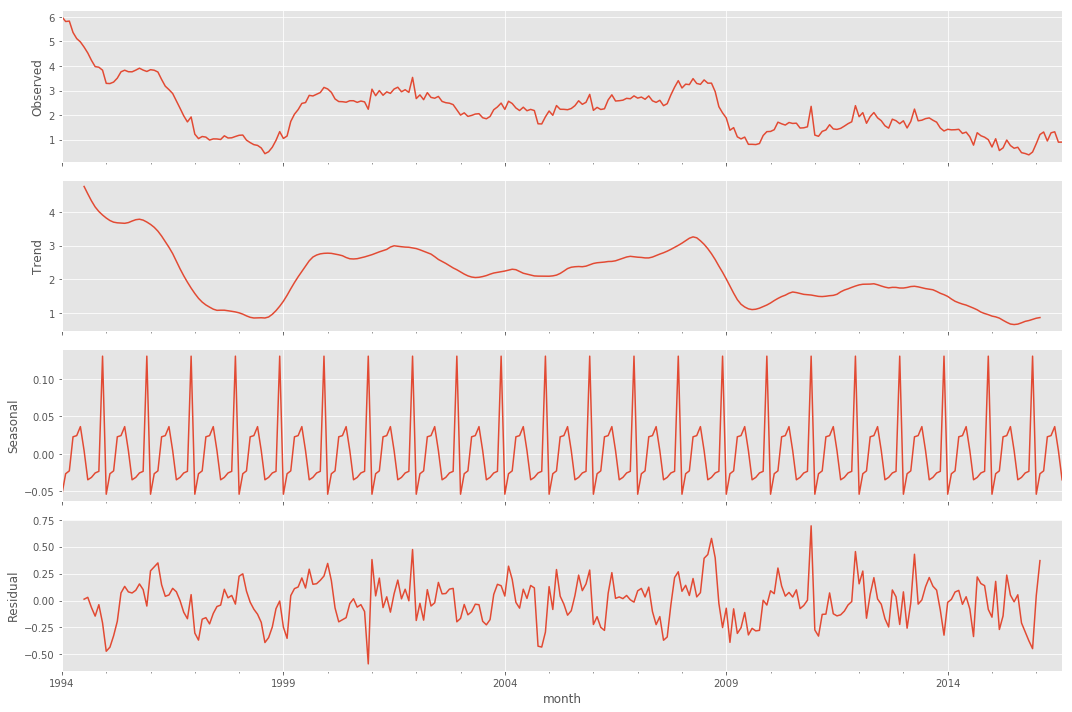

In [93]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print("The Augmented Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

# Differentiation

We still see trand but zero hypothesis could be neglected, but to be sure lets make differentiation

The Augmented Dickey-Fuller test: p=0.000000


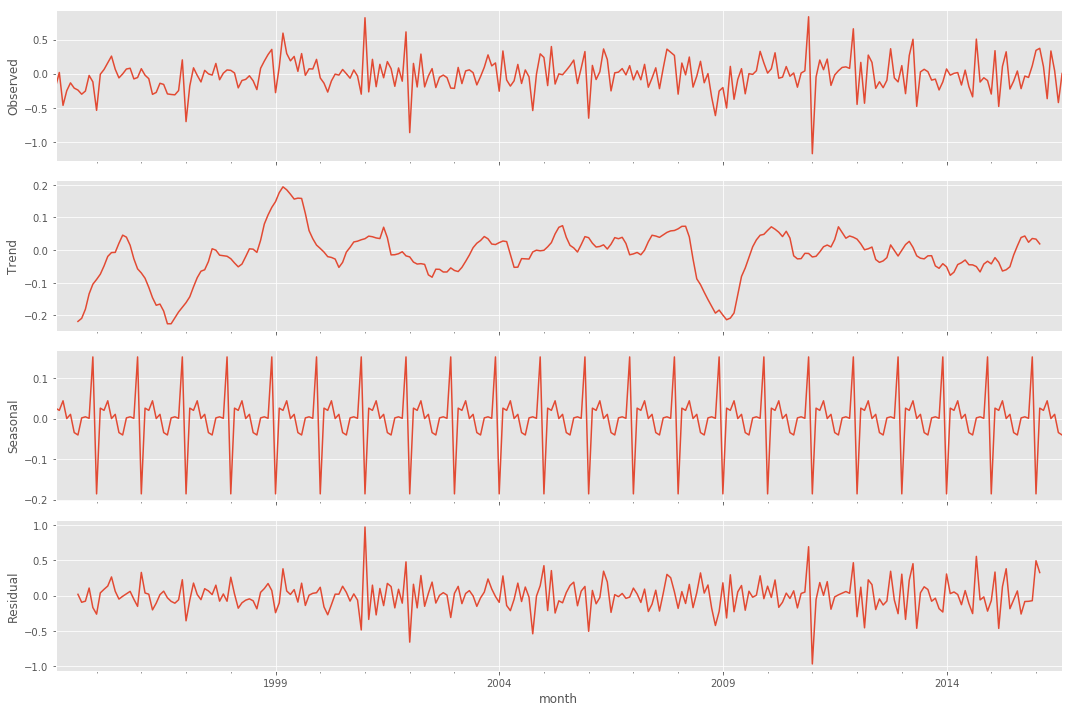

In [94]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()
print("The Augmented Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

Finally zero hypothesis could be neglected => row is stationary

# Selecting initial approximation for p,q,P,Q

Next step is build ACF and PACF to find Initial approximations for p,q,P,Q

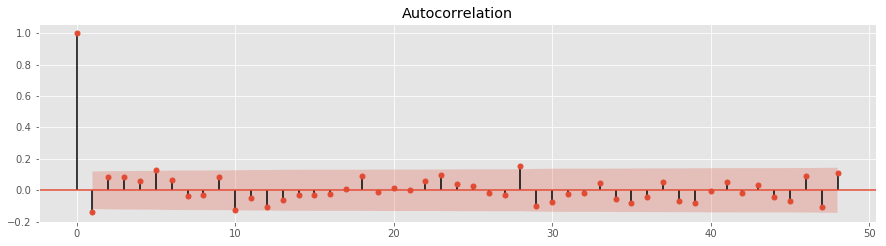

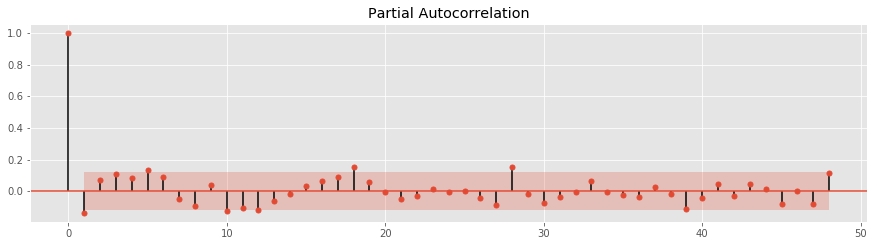

In [81]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [96]:
Q = 0
q = 5
P = 1
p = 5
ps = range(0, 2)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 6)
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

# Building and models comparing

In [97]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
import statsmodels.api as sm

for param in parameters_list:
    #try except needed because for some parameter sets model couls not be builded
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print this sets
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #save best model to aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 0, 2))
('wrong parameters:', (1, 2, 0, 3))
('wrong parameters:', (1, 2, 0, 4))
('wrong parameters:', (1, 2, 0, 5))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (1, 2, 1, 2))
('wrong parameters:', (1, 2, 1, 3))
('wrong parameters:', (1, 2, 1, 4))
('wrong parameters:', (1, 2, 1, 5))
CPU times: user 39min 55s, sys: 8.57 s, total: 40min 3s
Wall time: 20min 15s


In [98]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
125  (1, 5, 1, 0) -15.867143
126  (1, 5, 1, 1) -15.347251
120  (1, 5, 0, 1) -15.298495
121  (1, 5, 0, 2) -14.464731
119  (1, 5, 0, 0) -13.661216


In [99]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  15.934
Date:                            Sun, 23 Jul 2017   AIC                            -15.867
Time:                                    16:29:45   BIC                             13.325
Sample:                                01-01-1993   HQIC                            -4.164
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5844      0.153      3.815      0.000       0.284       0.885
ma.L1         -0.8118      0.155   

# Residues research

Build Residues series and heck Student criteria(zero hypothesis is mean value = 0)

Student criteria: p=0.281352
The Augmented Dickey-Fuller test: p=0.000000


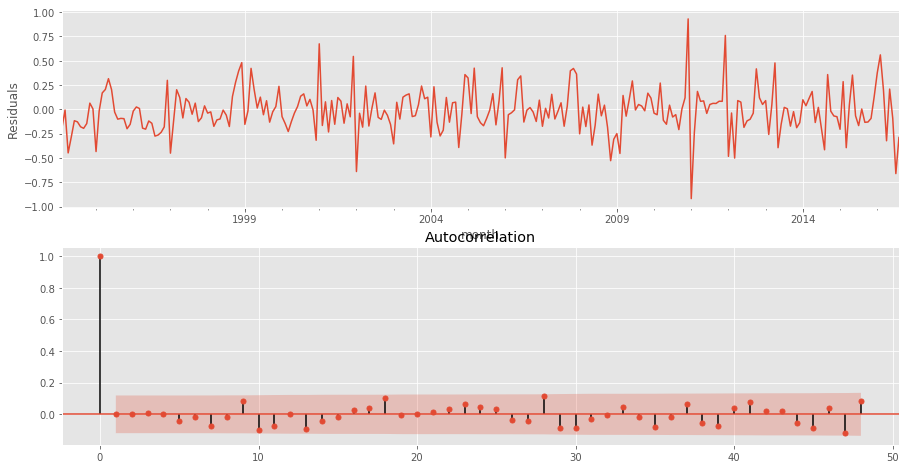

In [100]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
print("Student criteria: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("The Augmented Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

p-value for Student criteria is > 0.05 it means we could not neglect that mean value is 0
The Augmented Dickey-Fuller test prove that error row is stacionar

Show data and prediction on one plot

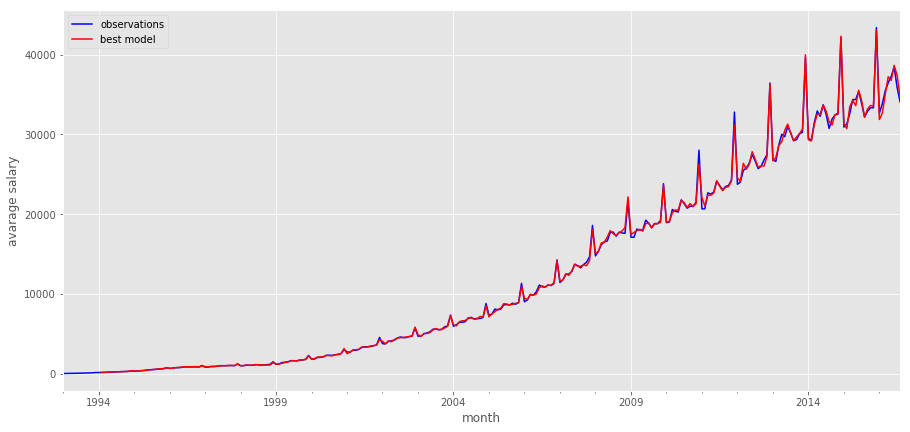

In [105]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot(color='b', label='observations')
data.model[13:].plot(color='r', label='best model')
pylab.legend()
plt.ylabel('avarage salary')
pylab.show()

Build prediction for next 3 years

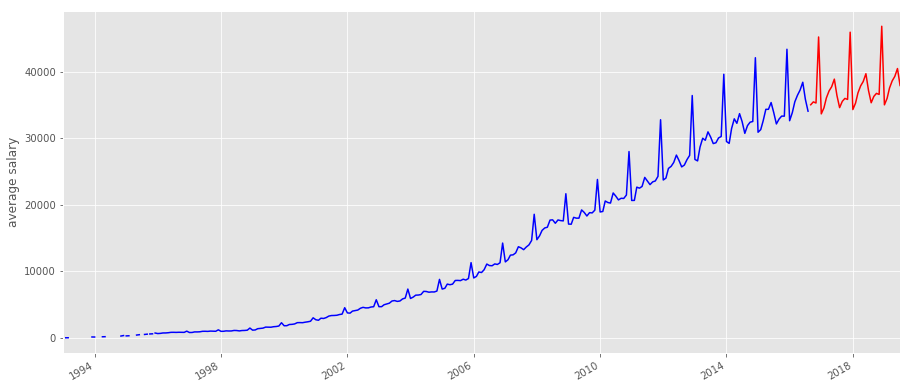

In [102]:
data3 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data3.columns)
data3 = pd.concat([data3, future])
data3['forecast'] = invboxcox(best_model.predict(start=len(data), end=len(data)+35), lmbda)#####

plt.figure(figsize(15,7))
data.WAG_C_M.plot(color='b')
data3.forecast.plot(color='r')
plt.ylabel('average salary')
pylab.show()

# Comparing with real data

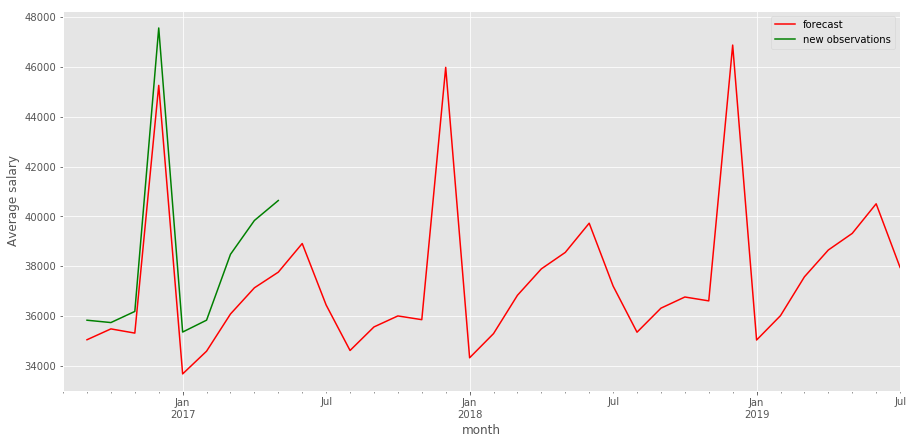

In [110]:
wag17 = pd.read_csv('WAG_C_M_17.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
data3.forecast[len(data):].plot(color='r', label='forecast')
wag17.WAG_C_M[len(data):].plot(color='g', label='new observations')
pylab.legend()
plt.ylabel('Average salary')
pylab.show()